In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Clustering

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
train_dataset = datasets.MNIST(root='./data', train = True, download = True)
test_dataset  = datasets.MNIST(root='./data', train = False, download = True)

X_train = train_dataset.data.float().view(train_dataset.data.shape[0], -1) / 255.0
X_test  = test_dataset.data.float().view(test_dataset.data.shape[0], -1) / 255.0
y_train = train_dataset.targets.numpy()
y_test = test_dataset.targets.numpy()

Adjusted Rand Index: 0.3609


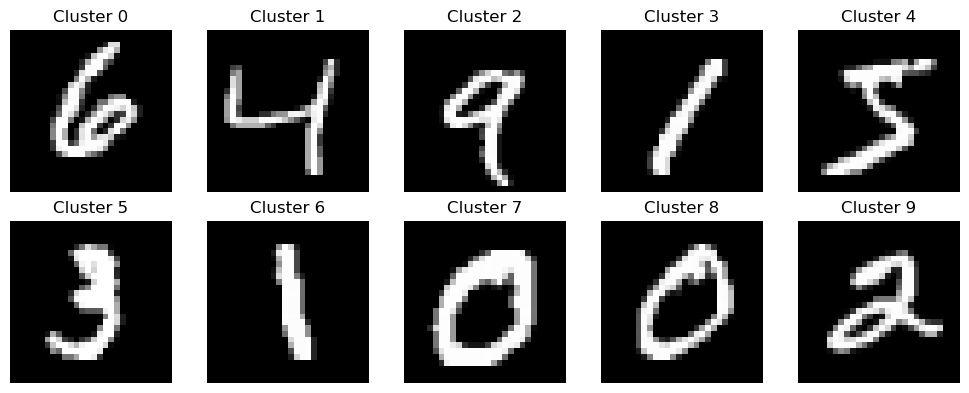

In [4]:
X_train_np = X_train.numpy()

# Apply KMeans clustering
n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters, random_state = 0, init = 'k-means++', n_init = 10)
cluster_labels = kmeans.fit_predict(X_train_np)

#Evaluate clustering
ari = adjusted_rand_score(y_train, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

#Select representative images for each cluster
cluster_representatives = []
for i in range(n_clusters):
    cluster_indices = (cluster_labels == i).nonzero()[0]
    if len(cluster_indices) > 0:
        cluster_representatives.append(cluster_indices[0])  # Pick first occurrence in cluster

#Visualize representative digits from each cluster
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < len(cluster_representatives):
        ax.imshow(train_dataset.data[cluster_representatives[i]], cmap='gray')
        ax.set_title(f'Cluster {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Segmentation

In [ ]:
#Read image
image = cv2.imread('./data/lily.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR -> RGB

In [7]:
#Preprocess: Image -> 2D array of pixel, float32
pixel_vals = image.reshape((-1, 3))
pixel_vals = np.float32(pixel_vals)

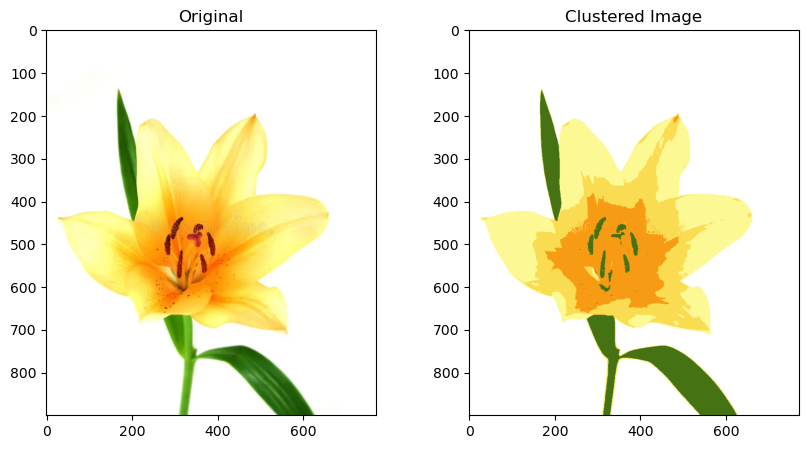

In [ ]:
#n-clusters
k = 5

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

#K-means
ret, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

#Convert centers to uint8
centers = np.uint8(centers)

#Assign each pixel to its cluster center
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

#VisualizeVisualize
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Original")
plt.imshow(image)
plt.subplot(122)
plt.title("Segmented Image")
plt.imshow(segmented_image)
plt.show()